In [34]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from modules import SAB, PMA
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


num_classes = 4


class SmallDeepSet(nn.Module):
    def __init__(self, pool="max"):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
        )
        self.dec = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes),
        )
        self.pool = pool

    def forward(self, x):
        x = self.enc(x)
        if self.pool == "max":
            x = x.max(dim=1)[0]
        elif self.pool == "mean":
            x = x.mean(dim=1)
        elif self.pool == "sum":
            x = x.sum(dim=1)
        x = self.dec(x)
        return x


class SmallSetTransformer(nn.Module):
    def __init__(self,):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=512, dim_out=64, num_heads=4),
            SAB(dim_in=64, dim_out=64, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=64, num_heads=4, num_seeds=1),
            nn.Linear(in_features=64, out_features=num_classes),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)



# Dataset class definition
class SetDataset(Dataset):
    def __init__(self, data_folder, annotations_file, mode='train'):
        self.data_folder = data_folder
        self.annotations = pd.read_csv(annotations_file)
        self.mode = mode
        self.annotations['path'] = self.annotations['filename'] + '_' + self.annotations['x_y'] + '.pt'
        self.annotations.set_index('path', inplace=True)
        self.data_files = [f for f in os.listdir(data_folder) if f.endswith('.pt')]
        if mode == 'train':
            self.data_files = [f for f in self.data_files if not any(x in f for x in ['case3', 'case4', 'control3', 'control4'])]
        else:
            self.data_files = [f for f in self.data_files if any(x in f for x in ['case3', 'case4', 'control3', 'control4'])]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, index):
        file_path = self.data_files[index]
        data = torch.load(os.path.join(self.data_folder, file_path))
        label = self.annotations.loc[file_path, 'level']
        label = torch.tensor(label, dtype=torch.long)
        return data, label


def create_sampler(train_dataset):
    # Count class instances
    class_counts = {}
    for _, label in train_dataset:
        label = label.item()  # Convert torch.Tensor to integer
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    # Calculate total number of samples and create weights for each class
    num_samples = len(train_dataset)
    class_weights = {cls: num_samples/class_counts[cls] for cls in class_counts}

    # Create weights for each sample based on the class weights
    sample_weights = [class_weights[label.item()] for _, label in train_dataset]  # label.item() to convert torch.Tensor to integer
    sample_weights = torch.DoubleTensor(sample_weights)

    # Create the sampler using the weights
    return WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    

def collate_fn(batch):
    xs, ys = zip(*batch)
    # Pad the sequences so they all have the same length
    xs = pad_sequence(xs, batch_first=True)
    ys = torch.tensor(ys, dtype=torch.long)
    return xs, ys



def train(model, data_loader, epochs, save_path):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss().to(device)
    
    losses = []
    accuracies = []

    # Set model to training mode
    model.train()
    
    for epoch in range(epochs):
        total_accuracy = 0
        total_loss = 0
        total_batches = 0
        
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            output = output.squeeze(1)
            
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate loss and accuracy
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            correct = (predictions == label).float().sum()
            accuracy = correct / label.shape[0]
            total_accuracy += accuracy.item()
            total_batches += 1

        avg_loss = total_loss / total_batches
        avg_accuracy = total_accuracy / total_batches
        losses.append(avg_loss)
        accuracies.append(avg_accuracy)
        
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    torch.save(model.state_dict(), save_path)
    
    # Plotting the training curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), accuracies, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    
    plt.show()

    return losses, accuracies



def evaluate(model, data_loader, load_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load(load_path))
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    
    total_loss = 0
    total_correct = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            output = output.squeeze(1)  # Ensure output is [batch_size, num_classes]
            loss = criterion(output, label)
            total_loss += loss.item()
            predictions = output.argmax(dim=1)
            total_correct += predictions.eq(label).sum().item()

            # Collect all predictions and labels for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", cm)
    return avg_loss, accuracy




# def evaluate(model, data_loader, load_path):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.load_state_dict(torch.load(load_path))
#     model.eval()
#     criterion = nn.CrossEntropyLoss().to(device)
    
#     total_loss = 0
#     total_correct = 0
#     all_predictions = []
#     all_labels = []

#     with torch.no_grad():
#         for data, label in data_loader:
#             data = data.to(device)
#             label = label.to(device)
#             output = model(data)
#             output = output.squeeze(1)  # Ensure output is [batch_size, num_classes]

#             loss = criterion(output, label)
#             total_loss += loss.item()
#             predictions = output.argmax(dim=1)
#             total_correct += predictions.eq(label).sum().item()

#             # Collect all predictions and labels for confusion matrix
#             all_predictions.extend(predictions.cpu().numpy())
#             all_labels.extend(label.cpu().numpy())

#     avg_loss = total_loss / len(data_loader)
#     accuracy = total_correct / len(data_loader.dataset)
#     print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

#     # Compute the confusion matrix
#     cm = confusion_matrix(all_labels, all_predictions)
#     print("Confusion Matrix:\n", cm)
#     return avg_loss, accuracy






# def evaluate(model, data_loader, load_path):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Load the saved weights
#     model.load_state_dict(torch.load(load_path))

#     model.eval()
#     criterion = nn.CrossEntropyLoss().to(device)
#     total_loss = 0
#     total_correct = 0
#     with torch.no_grad():
#         for data, label in data_loader:
#             data = data.to(device)
#             label = label.to(device)
#             output = model(data)
#             output = output.squeeze(1)
#             loss = criterion(output, label)
#             total_loss += loss.item()
#             predictions = output.argmax(dim=1, keepdim=True)
#             total_correct += predictions.eq(label.view_as(predictions)).sum().item()
            

#     avg_loss = total_loss / len(data_loader)
#     accuracy = total_correct / len(data_loader.dataset)
#     print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
#     return avg_loss, accuracy




Epoch 1, Loss: 1.3865, Accuracy: 0.2731
Epoch 2, Loss: 1.3855, Accuracy: 0.2620
Epoch 3, Loss: 1.3858, Accuracy: 0.2481
Epoch 4, Loss: 1.3854, Accuracy: 0.2269
Epoch 5, Loss: 1.3763, Accuracy: 0.3593
Epoch 6, Loss: 1.3753, Accuracy: 0.3704
Epoch 7, Loss: 1.3651, Accuracy: 0.3537
Epoch 8, Loss: 1.3562, Accuracy: 0.3380
Epoch 9, Loss: 1.3374, Accuracy: 0.3704
Epoch 10, Loss: 1.2919, Accuracy: 0.3685
Epoch 11, Loss: 1.2933, Accuracy: 0.3694
Epoch 12, Loss: 1.2398, Accuracy: 0.3731
Epoch 13, Loss: 1.2204, Accuracy: 0.4037
Epoch 14, Loss: 1.2029, Accuracy: 0.4046
Epoch 15, Loss: 1.1562, Accuracy: 0.3667
Epoch 16, Loss: 1.2067, Accuracy: 0.3750
Epoch 17, Loss: 1.1585, Accuracy: 0.4157
Epoch 18, Loss: 1.1543, Accuracy: 0.3963
Epoch 19, Loss: 1.1464, Accuracy: 0.4102
Epoch 20, Loss: 1.1473, Accuracy: 0.3704
Epoch 21, Loss: 1.1131, Accuracy: 0.4167
Epoch 22, Loss: 1.0910, Accuracy: 0.4213
Epoch 23, Loss: 1.1110, Accuracy: 0.4435
Epoch 24, Loss: 1.0637, Accuracy: 0.4417
Epoch 25, Loss: 1.0876, A

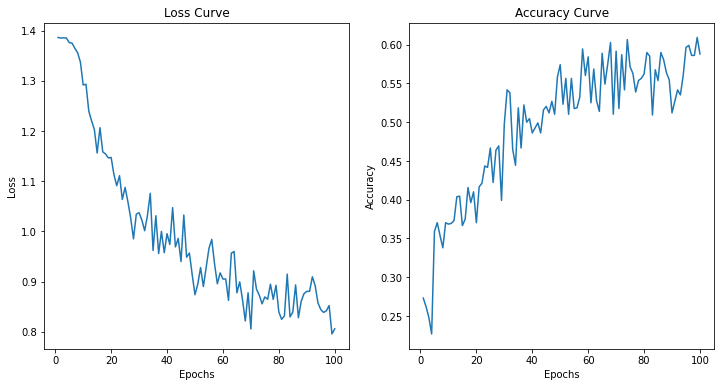

Test Loss: 1.3074, Accuracy: 0.4500
Confusion Matrix:
 [[ 2  0  4  1]
 [ 4  0  6  1]
 [ 3  0  6  1]
 [ 1  0  1 10]]


(1.3074104487895966, 0.45)

In [36]:
data_folder = '/projectnb/ec500kb/projects/project7/GTEx/annotated_patches/plip_features' # the path for the stored features
annotations_file = '/projectnb/ec500kb/projects/project7/GTEx/annotated_patches/annotations.csv'

train_dataset = SetDataset(data_folder, annotations_file, mode='train')
train_sampler = create_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn, sampler=train_sampler)

test_dataset = SetDataset(data_folder, annotations_file, mode='test')
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True, collate_fn=collate_fn)


# Assuming you have a Set Transformer model defined as 'model'
model = SmallDeepSet()

train_path = '/projectnb/ec500kb/projects/project7/set_transformer/model_1_plip.pth'
# evaluate_path = '/projectnb/ec500kb/projects/project7/set_transformer/model_resnet1_plip.pth'

losses = train(model, train_loader, epochs=100, save_path=train_path)
evaluate(model, test_loader, load_path=train_path)